# Test of largescale space + lateral erosion
<hr>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
import copy
import matplotlib as mpl
import pytest
from numpy import testing

from landlab import imshow_grid,imshowhs_grid, RasterModelGrid
from landlab.components import (
    SpaceLargeScaleEroder,
    PriorityFloodFlowRouter,
    LateralEroderSolo, 
    BedrockLandslider
)

Create raster grid with space

In [2]:
# nr = 20
# nc = 20
nr = 75
nc = 75
xy_spacing = 10.0
mg = RasterModelGrid((nr, nc), xy_spacing=xy_spacing)
z = mg.add_ones("topographic__elevation", at="node")
mg.at_node["topographic__elevation"][mg.core_nodes] += np.random.rand(
    mg.number_of_core_nodes
)

s = mg.add_zeros("soil__depth", at="node", dtype=float)
mg.at_node["soil__depth"][mg.core_nodes] += 0.5
mg.at_node["topographic__elevation"] += mg.at_node["soil__depth"]

fr = PriorityFloodFlowRouter(mg, flow_metric="D8", update_flow_depressions=True)

ha = SpaceLargeScaleEroder(mg, K_sed=0.00005, K_br=0.00005, phi=0.3, H_star=1)

br = mg.at_node["bedrock__elevation"]
z = mg.at_node["topographic__elevation"]

space_dt = 500

Below is creating the lateral erosion component. Note the Kl/Kv ratio is really high here (5, rather than 1, 1.5, etc.).

On 10 January 2023, updated new lateral erosion component to take a variable named K_sed to laterall erode bedrock AND sediment.


In [3]:
le = LateralEroderSolo(mg, K_br=0.00005, Kl_ratio = 5, K_sed=0.000075)

In the block below, we compare sediment flux from the space component to the sediment flux from the lateral erosion component. These two values should *not* be equal to each other, because lateral erosion is providing additional sediment flux.

In [4]:
z_ori = np.array(z)
for i in tqdm(range(500)):
    # Uplift
    br[mg.core_nodes] += 0.001 * space_dt

    z[mg.core_nodes] = br[mg.core_nodes] + s[mg.core_nodes]

    fr.run_one_step()
    ha.run_one_step(dt=space_dt)
    sedflux_space = np.copy(mg.at_node["sediment__flux"])

    le.run_one_step_basic(dt=space_dt)
    sedflux_lateral = mg.at_node["sediment__flux"]
    ### test for match with sed fluxes before and after lateral erosion component
    # lat ero component should add to sed flux from eroded lateral node to downstream node
    testing.assert_array_almost_equal(
        sedflux_space,
        sedflux_lateral,
        decimal=8,
        err_msg="sediment flux IS being changed in lateral erosion module",
        verbose=True,
    )


  0%|                                                                                          | 0/500 [00:00<?, ?it/s]


AssertionError: 
Arrays are not almost equal to 8 decimals
sediment flux IS being changed in lateral erosion module
Mismatched elements: 755 / 5625 (13.4%)
Max absolute difference: 0.6342272962766125
Max relative difference: 0.9098035776761725
 x: array([ 0.,  0.,  0., ...,  0.,  0.,  0.])
 y: array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In the code block below testing to make sure that lateral erosion is reducing elevation from soil depth and bedrock elevation properly. topographic__elevation should be equal to bedrock__elevation + soil__depth.

In [5]:
z_ori = np.array(z)
for i in tqdm(range(50)):
    
    fr.run_one_step()
    ha.run_one_step(dt=space_dt)
    le.run_one_step_basic(dt=space_dt)
    
### test to make sure that lateral erosion is reducing elevation from soil depth
# and bedrock elevation properly. topographic__elevation should be equal to 
# bedrock__elevation + soil__depth
br_soil = mg.at_node["soil__depth"]+mg.at_node["bedrock__elevation"]

testing.assert_array_almost_equal(
    mg.at_node["topographic__elevation"],
    br_soil,
    decimal=8,
    err_msg="topographic_elevation is NOT almost equal to bedrock__elevation + soil__depth",
    verbose=True,
)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:37<00:00,  1.34it/s]


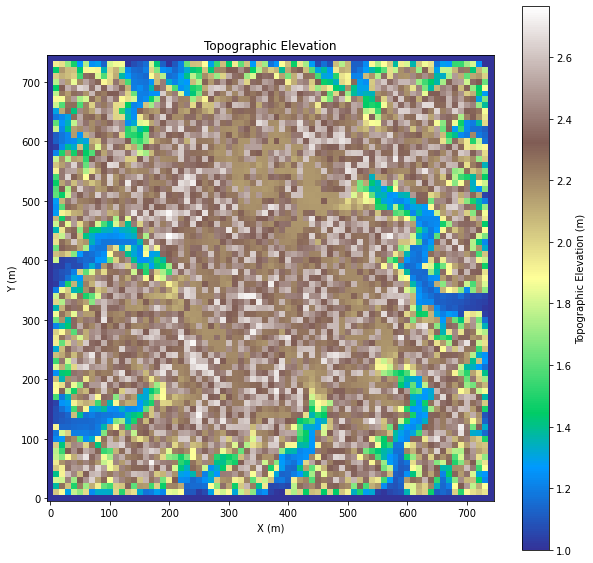

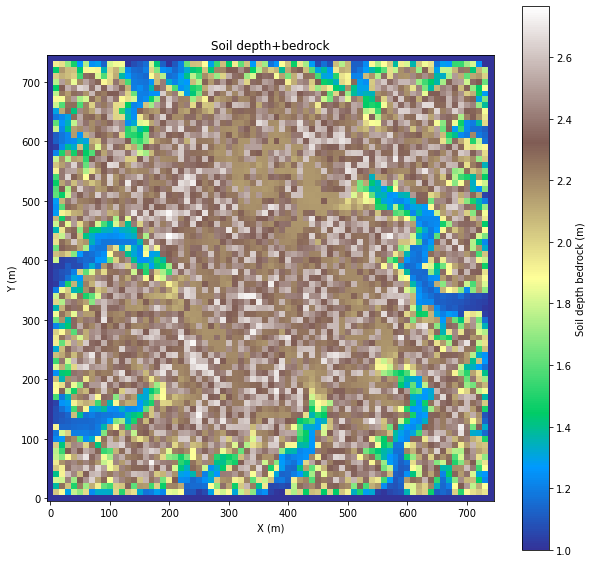

In [6]:
plt.figure(figsize=(10,10))
plot = plt.subplot()
imshow_grid(
    mg,
    "topographic__elevation",
    plot_name="Topographic Elevation",
    var_name="Topographic Elevation",
    var_units=r"m",
    grid_units=("m", "m"),
    cmap="terrain"
)
br_soil = mg.at_node["soil__depth"]+mg.at_node["bedrock__elevation"]
plt.figure(figsize=(10,10))
imshow_grid(
    mg,
    br_soil,
    plot_name="Soil depth+bedrock",
    var_name="Soil depth bedrock",
    var_units=r"m",
    grid_units=("m", "m"),
    cmap="terrain"
)

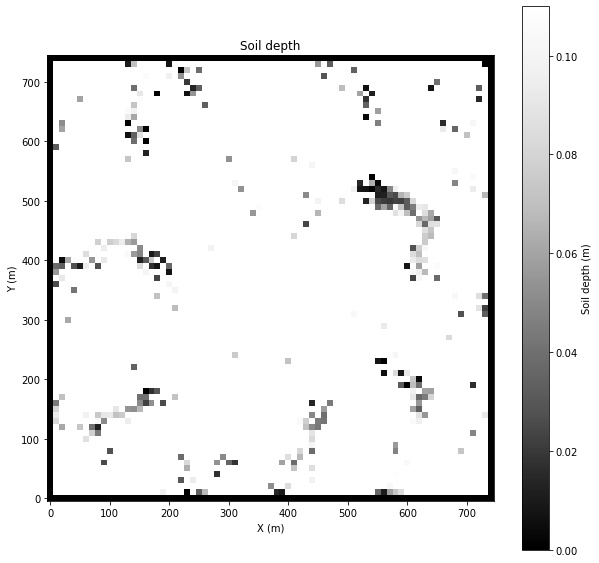

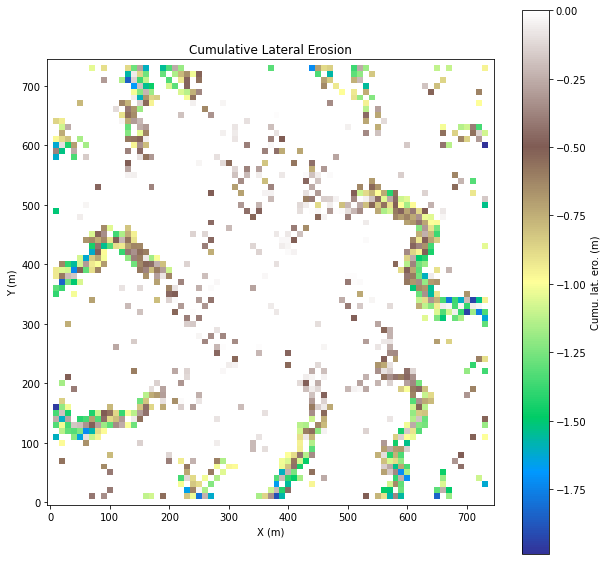

In [7]:
plt.figure(figsize=(10,10))
imshow_grid(
    mg,
    "soil__depth",
    plot_name="Soil depth",
    var_name="Soil depth",
    var_units=r"m",
    grid_units=("m", "m"),
    cmap="Greys_r",
    vmax=0.11
)

plt.figure(figsize=(10,10))
imshow_grid(
    mg,
    "lateral_erosion__depth_cumu",
    plot_name="Cumulative Lateral Erosion",
    var_name="Cumu. lat. ero.",
    var_units=r"m",
    grid_units=("m", "m"),
    cmap="terrain",
)